Saving data_summer2025.csv to data_summer2025 (5).csv
Loaded file: data_summer2025 (5).csv
Dataset shape: (1208, 12)
Columns: ['name', 'position', 'age', 'market_value', 'country_from', 'league_from', 'club_from', 'country_to', 'league_to', 'club_to', 'fee', 'loan']
Valid fee rows (non-loan, fee parsed): 480
Elite sample size: 480 transfers (Top 500 by fee)
After cleaning (elite sample): (365, 16)


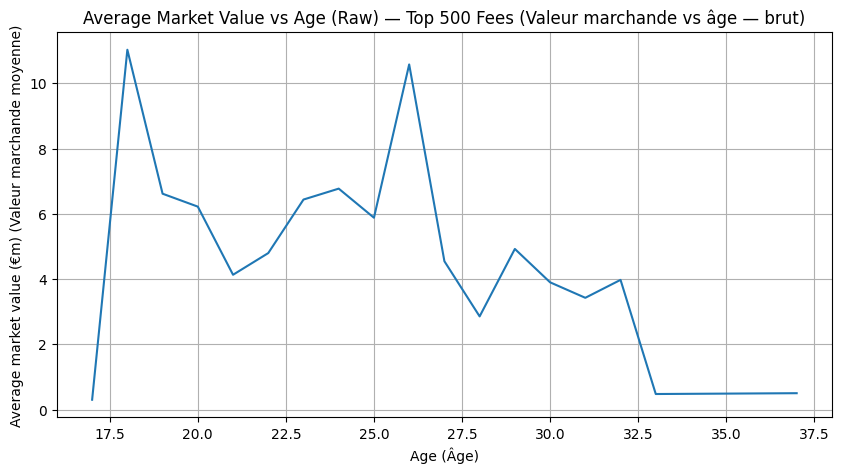

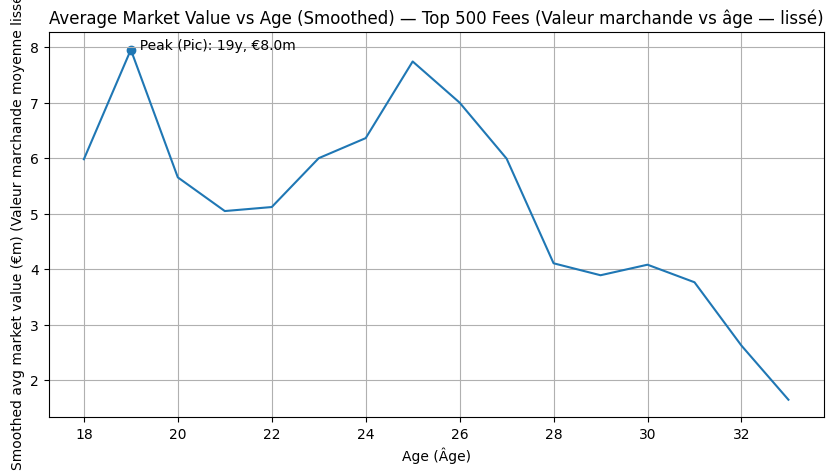

<Figure size 1000x500 with 0 Axes>

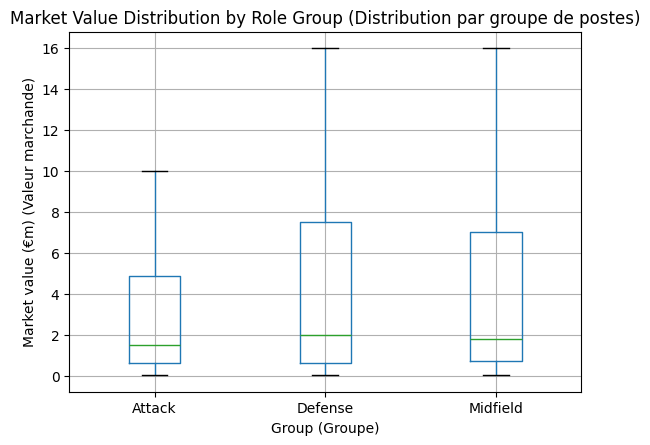

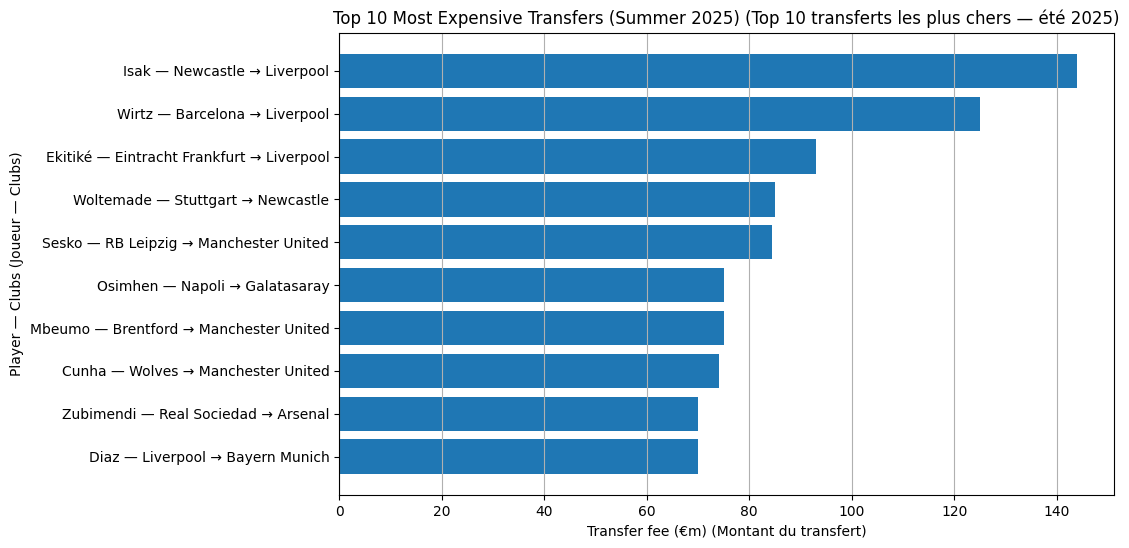


KEY INSIGHTS (Points clés) — TOP 500 FEES SAMPLE (Échantillon Top 500 transferts)
--------------------------------------------------------------------------
- Sample definition: Top 500 transfers by fee (Définition : Top 500 transferts par montant)
- Clean sample size: 365 rows (Taille après nettoyage)
- Peak (smoothed) average market value occurs around age 19: €7.96m (Pic de valeur moyenne lissée ~ 19 ans)
- Position chart uses ONLY 3 groups: Defense / Midfield / Attack (Défense / Milieu / Attaque)
- Top 10 transfer chart is sourced from the provided Summer 2025 graphic (not from the dataset).

--- README snippet (copier-coller dans README.md) ---

## Method overview

### Why a Top 500 sample?
To focus on meaningful 'elite market' dynamics, the analysis restricts the dataset to the **Top 500 most expensive transfers** (ranked by `fee`).
This reduces noise from low-fee / free transfers and makes age-related patterns clearer for high-stakes deals.

### Position comparison (3 groups on

In [8]:
# ==============================
# Football Market Value vs Age
# Full executable Colab script (TOP 500 most expensive transfers sample)
# Updates requested:
# 1) Position plot: only 3 groups -> Attack / Midfield / Defense (Attaque / Milieu / Défense)
# 2) Top 10 transfers chart: DO NOT use dataset, use the provided Summer 2025 graphic (hardcoded list)
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ------------------------------
# 1) DATA LOADING (Colab upload)
# ------------------------------
from google.colab import files

uploaded = files.upload()  # upload your CSV (e.g., data_summer2025.csv)
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print("Loaded file:", filename)
print("Dataset shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

# ------------------------------
# 2) HELPERS
# ------------------------------
def parse_market_value_eur(x):
    """
    Market value column looks like "€75.00m" or "€500k".
    Parse to EUR.
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in ["nan", "", "none", "null", "-", "—"]:
        return np.nan

    s = s.replace("€", "").replace("$", "").replace(",", "").replace(" ", "")

    mult = 1.0
    if s.endswith("m"):
        mult = 1_000_000.0
        s = s[:-1]
    elif s.endswith("k"):
        mult = 1_000.0
        s = s[:-1]

    try:
        return float(s) * mult
    except:
        return np.nan


def parse_fee_eur(x):
    """
    Dataset-specific fix:
    - fee is often a plain number like "74.2" meaning €74.2m
    - sometimes "500k"
    - ignore non-numeric labels
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in ["nan", "", "none", "null", "-", "—"]:
        return np.nan

    if any(token in s for token in ["loan", "free", "undisclosed", "n/a", "tbd", "?", "unknown"]):
        return np.nan

    s = s.replace("€", "").replace("$", "").replace(",", "").replace(" ", "")

    # pure number -> assume millions
    if re.fullmatch(r"\d+(\.\d+)?", s):
        val = float(s)
        return np.nan if val <= 0 else val * 1_000_000.0

    mult = 1.0
    if s.endswith("m"):
        mult = 1_000_000.0
        s = s[:-1]
    elif s.endswith("k"):
        mult = 1_000.0
        s = s[:-1]

    try:
        val = float(s) * mult
        return np.nan if val <= 0 else val
    except:
        return np.nan


def normalize_position(pos):
    """Merge Right/Left Winger -> Winger, keep everything else as-is."""
    if pd.isna(pos):
        return np.nan
    s = str(pos).strip()
    s_low = s.lower()

    if s_low in ["right winger", "left winger", "rw", "lw"]:
        return "Winger"
    if "winger" in s_low and ("right" in s_low or "left" in s_low):
        return "Winger"
    return s


def map_to_3_groups(pos_clean):
    """
    Map detailed positions into ONLY 3 groups:
    - Attack (Attaque)
    - Midfield (Milieu)
    - Defense (Défense)

    Goalkeepers are excluded (return NaN) so the graph contains only these 3 groups.
    """
    if pd.isna(pos_clean):
        return np.nan
    p = str(pos_clean).strip().lower()

    # Exclude GK (user asked only 3 groups)
    if "goalkeeper" in p or p in ["gk", "keeper"]:
        return np.nan

    # Defense keywords
    defense_kw = [
        "back", "full-back", "fullback", "wing-back", "wingback",
        "centre-back", "center-back", "cb", "defender", "defence", "defense"
    ]
    if any(k in p for k in defense_kw):
        return "Defense"

    # Midfield keywords
    midfield_kw = [
        "midfield", "midfielder", "cm", "cdm", "dm", "am", "cam",
        "central midfield", "defensive midfield", "attacking midfield"
    ]
    if any(k in p for k in midfield_kw):
        return "Midfield"

    # Attack keywords (incl. winger)
    attack_kw = [
        "forward", "striker", "centre-forward", "center-forward",
        "second striker", "winger", "cf", "st", "rw", "lw"
    ]
    if any(k in p for k in attack_kw):
        return "Attack"

    # If unknown, return NaN (keeps graph clean)
    return np.nan


# ------------------------------
# 3) BUILD ELITE SAMPLE: TOP 500 MOST EXPENSIVE TRANSFERS (by fee from dataset)
# ------------------------------
needed_fee_cols = ["fee", "name", "club_to"]
missing_fee_cols = [c for c in needed_fee_cols if c not in df.columns]
if missing_fee_cols:
    raise ValueError(f"Missing columns required for transfer-fee sampling: {missing_fee_cols}")

df_fee = df.copy()
df_fee["fee_eur"] = df_fee["fee"].apply(parse_fee_eur)

# Exclude loans if loan column exists
if "loan" in df_fee.columns:
    loan_str = df_fee["loan"].astype(str).str.lower()
    df_fee = df_fee[~loan_str.isin(["true", "yes", "1"])].copy()

df_fee = df_fee.dropna(subset=["fee_eur"]).copy()
df_fee = df_fee[df_fee["fee_eur"] > 0].copy()

print("Valid fee rows (non-loan, fee parsed):", df_fee.shape[0])

TOP_N = 500
df_fee_sorted = df_fee.sort_values("fee_eur", ascending=False).copy()
sample = df_fee_sorted.head(TOP_N).copy()
print(f"Elite sample size: {sample.shape[0]} transfers (Top {TOP_N} by fee)")

# ------------------------------
# 4) DATA CLEANING (on elite sample)
# ------------------------------
required_cols = ["age", "market_value"]
missing = [c for c in required_cols if c not in sample.columns]
if missing:
    raise ValueError(f"Missing required columns for analysis: {missing}")

sample["age"] = pd.to_numeric(sample["age"], errors="coerce")
sample["market_value_eur"] = sample["market_value"].apply(parse_market_value_eur)

if "position" in sample.columns:
    sample["position_clean"] = sample["position"].apply(normalize_position)
    sample["position_group"] = sample["position_clean"].apply(map_to_3_groups)
else:
    sample["position_clean"] = np.nan
    sample["position_group"] = np.nan

clean = sample.dropna(subset=["age", "market_value_eur"]).copy()
clean = clean[(clean["age"] >= 15) & (clean["age"] <= 45)]
clean = clean[clean["market_value_eur"] > 0]
print("After cleaning (elite sample):", clean.shape)

# ------------------------------
# 5) FEATURE ENGINEERING
# ------------------------------
clean["market_value_m"] = clean["market_value_eur"] / 1_000_000  # €m
clean["fee_m"] = clean["fee_eur"] / 1_000_000  # €m

# ------------------------------
# 6) EDA — AGE ANALYSIS (2 separate charts)
# ------------------------------
avg_by_age = (
    clean.groupby("age")["market_value_m"]
    .mean()
    .reset_index()
    .sort_values("age")
)

# Chart 1: Raw average
plt.figure(figsize=(10,5))
plt.plot(avg_by_age["age"], avg_by_age["market_value_m"])
plt.xlabel("Age (Âge)")
plt.ylabel("Average market value (€m) (Valeur marchande moyenne)")
plt.title("Average Market Value vs Age (Raw) — Top 500 Fees (Valeur marchande vs âge — brut)")
plt.grid(True)
plt.show()

# Chart 2: Smoothed average (rolling mean)
avg_by_age["smoothed"] = avg_by_age["market_value_m"].rolling(3, center=True).mean()
peak_row = avg_by_age.dropna(subset=["smoothed"]).loc[avg_by_age["smoothed"].idxmax()]
peak_age = int(peak_row["age"])
peak_value = float(peak_row["smoothed"])

plt.figure(figsize=(10,5))
plt.plot(avg_by_age["age"], avg_by_age["smoothed"])
plt.scatter([peak_age], [peak_value])
plt.text(peak_age, peak_value, f"  Peak (Pic): {peak_age}y, €{peak_value:.1f}m")
plt.xlabel("Age (Âge)")
plt.ylabel("Smoothed avg market value (€m) (Valeur marchande moyenne lissée)")
plt.title("Average Market Value vs Age (Smoothed) — Top 500 Fees (Valeur marchande vs âge — lissé)")
plt.grid(True)
plt.show()

# ------------------------------
# 7) POSITION COMPARISON (ONLY 3 groups): Attack / Midfield / Defense
# ------------------------------
pos3 = clean.dropna(subset=["position_group"]).copy()
pos3 = pos3[pos3["position_group"].isin(["Attack", "Midfield", "Defense"])].copy()

if len(pos3) > 0:
    order = ["Defense", "Midfield", "Attack"]  # readable progression

    plt.figure(figsize=(10,5))
    pos3.boxplot(
        column="market_value_m",
        by="position_group",
        grid=True,
        showfliers=False
    )

    plt.xlabel("Group (Groupe)")
    plt.ylabel("Market value (€m) (Valeur marchande)")
    plt.title("Market Value Distribution by Role Group (Distribution par groupe de postes)")
    plt.suptitle("")
    plt.show()
else:
    print("No usable positions to build the 3-group chart. Skipping position comparison.")

# ------------------------------
# 8) TOP 10 MOST EXPENSIVE TRANSFERS — FROM THE PROVIDED IMAGE (NOT from dataset)
# ------------------------------
# Values and clubs are taken from your image (Summer Window 2025/26 graphic).
# We purposely do NOT use df['fee'] here, as requested.

top10_img = [
    {"player": "Isak",      "from": "Newcastle",          "to": "Liverpool",          "fee_m": 144.0},
    {"player": "Wirtz",     "from": "Barcelona",          "to": "Liverpool",          "fee_m": 125.0},
    {"player": "Ekitiké",   "from": "Eintracht Frankfurt","to": "Liverpool",          "fee_m": 93.0},
    {"player": "Woltemade", "from": "Stuttgart",          "to": "Newcastle",          "fee_m": 85.0},
    {"player": "Sesko",     "from": "RB Leipzig",         "to": "Manchester United",  "fee_m": 84.5},
    {"player": "Mbeumo",    "from": "Brentford",          "to": "Manchester United",  "fee_m": 75.0},
    {"player": "Osimhen",   "from": "Napoli",             "to": "Galatasaray",        "fee_m": 75.0},
    {"player": "Cunha",     "from": "Wolves",             "to": "Manchester United",  "fee_m": 74.2},
    {"player": "Zubimendi", "from": "Real Sociedad",      "to": "Arsenal",            "fee_m": 70.0},
    {"player": "Diaz",      "from": "Liverpool",          "to": "Bayern Munich",      "fee_m": 70.0},
]

top10_df = pd.DataFrame(top10_img).sort_values("fee_m", ascending=False).copy()
top10_df["label"] = top10_df["player"] + " — " + top10_df["from"] + " → " + top10_df["to"]

# Plot as horizontal bars (ascending for barh)
top10_plot = top10_df.sort_values("fee_m", ascending=True)

plt.figure(figsize=(10,6))
plt.barh(top10_plot["label"], top10_plot["fee_m"])
plt.xlabel("Transfer fee (€m) (Montant du transfert)")
plt.ylabel("Player — Clubs (Joueur — Clubs)")
plt.title("Top 10 Most Expensive Transfers (Summer 2025) (Top 10 transferts les plus chers — été 2025)")
plt.grid(True, axis="x")
plt.show()

# ------------------------------
# 9) KEY INSIGHTS (AUTO)
# ------------------------------
print("\nKEY INSIGHTS (Points clés) — TOP 500 FEES SAMPLE (Échantillon Top 500 transferts)")
print("--------------------------------------------------------------------------")
print(f"- Sample definition: Top {TOP_N} transfers by fee (Définition : Top {TOP_N} transferts par montant)")
print(f"- Clean sample size: {clean.shape[0]} rows (Taille après nettoyage)")
print(f"- Peak (smoothed) average market value occurs around age {peak_age}: €{peak_value:.2f}m "
      f"(Pic de valeur moyenne lissée ~ {peak_age} ans)")
if len(pos3) > 0:
    print(f"- Position chart uses ONLY 3 groups: Defense / Midfield / Attack (Défense / Milieu / Attaque)")
print(f"- Top 10 transfer chart is sourced from the provided Summer 2025 graphic (not from the dataset).")

# ------------------------------
# 10) README SNIPPET (copy/paste into README.md)
# ------------------------------
readme_text = f"""
## Method overview

### Why a Top {TOP_N} sample?
To focus on meaningful 'elite market' dynamics, the analysis restricts the dataset to the **Top {TOP_N} most expensive transfers** (ranked by `fee`).
This reduces noise from low-fee / free transfers and makes age-related patterns clearer for high-stakes deals.

### Position comparison (3 groups only)
Instead of plotting positions by age, we compare **market value distributions** across **three tactical groups**:
- **Defense (Défense)**
- **Midfield (Milieu)**
- **Attack (Attaque)**

We also normalize winger labels by merging **Right/Left Winger → Winger**, then map detailed positions into the 3 groups.

### Top 10 most expensive transfers (Summer 2025)
The Top 10 chart is **not** computed from the dataset. It is **manually built** from the provided Summer 2025 infographic to match that specific transfer window’s ranking.
"""

print("\n--- README snippet (copier-coller dans README.md) ---")
print(readme_text)
